<a href="https://colab.research.google.com/github/lIIIIllIIllll/AI_lab/blob/main/Week_9_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [2]:
import os, zipfile, shutil
from google.colab import files

uploaded = files.upload()
zip_name = next(iter(uploaded))

extract_root = '/content'
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_root)

def find_split_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        lower = {d.lower() for d in dirnames}
        if {'train','val'}.issubset(lower):
            return dirpath
    return None

split_root = find_split_root(extract_root)
if split_root is None:
    raise RuntimeError("ZIP 안에서 'train'과 'val' 폴더를 찾지 못했습니다. "
                       "구조가 train/val/<class>/... 형태인지 확인하세요.")

target_dir = '/content/data/hymenoptera_data'
os.makedirs('/content/data', exist_ok=True)

if os.path.islink(target_dir) or os.path.exists(target_dir):
    try:
        if os.path.islink(target_dir):
            os.unlink(target_dir)
        else:
            shutil.rmtree(target_dir)
    except Exception:
        pass

try:
    os.symlink(split_root, target_dir, target_is_directory=True)
    print(f"[OK] Linked {split_root} -> {target_dir}")
except OSError:
    shutil.copytree(split_root, target_dir)
    print(f"[OK] Copied {split_root} -> {target_dir}")

print("train classes:", os.listdir(os.path.join(target_dir, 'train'))[:5])
print("val classes:", os.listdir(os.path.join(target_dir, 'val'))[:5])

Saving sample_computer_vision.zip to sample_computer_vision.zip
[OK] Linked /content/sample_computer_vision -> /content/data/hymenoptera_data
train classes: ['dogs', 'cats']
val classes: ['dogs', 'cats']


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


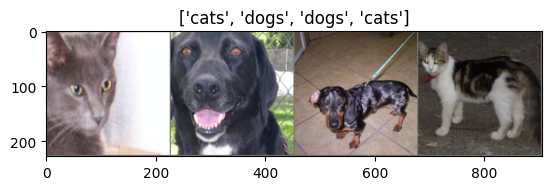

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5592 Acc: 0.7984
val Loss: 0.1436 Acc: 0.9400

Epoch 1/24
----------
train Loss: 0.4854 Acc: 0.7924
val Loss: 0.2545 Acc: 0.9100

Epoch 2/24
----------
train Loss: 0.5313 Acc: 0.7914
val Loss: 0.1220 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.4734 Acc: 0.8034
val Loss: 0.1282 Acc: 0.9600

Epoch 4/24
----------
train Loss: 0.5259 Acc: 0.8094
val Loss: 0.2076 Acc: 0.9250

Epoch 5/24
----------
train Loss: 0.5288 Acc: 0.8014
val Loss: 0.3472 Acc: 0.8900

Epoch 6/24
----------
train Loss: 0.4763 Acc: 0.8064
val Loss: 0.1161 Acc: 0.9700

Epoch 7/24
----------
train Loss: 0.2785 Acc: 0.8782
val Loss: 0.1159 Acc: 0.9700

Epoch 8/24
----------
train Loss: 0.3182 Acc: 0.8653
val Loss: 0.1218 Acc: 0.9750

Epoch 9/24
----------
train Loss: 0.2980 Acc: 0.8762
val Loss: 0.1073 Acc: 0.9850

Epoch 10/24
----------
train Loss: 0.2702 Acc: 0.8882
val Loss: 0.1231 Acc: 0.9750

Epoch 11/24
----------
train Loss: 0.2749 Acc: 0.8842
val Loss: 0.1077 Acc: 0.9750

Ep

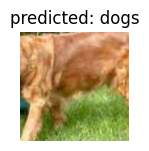

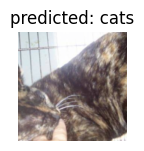

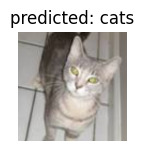

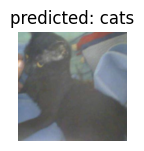

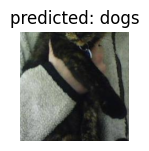

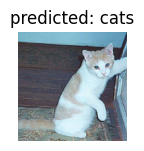

In [9]:
visualize_model(model_ft)